In [ ]:
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as pyplot
from os import path

def normalizedRGB(img):
    if img.dtype == np.uint8:
        return img[:,:,:3] / 255.
    else:
        return img[:,:,:3].astype(np.float64)
        
def mix(a, b, u, keepImag=False):
    if keepImag:
        return (a.real * (1 - u) + b.real * u) + a.imag * 1j
    else:
        return a * (1 - u) + b * u
    
def centralize(img, side=0.06, clip=False):
    img = img.real.astype(np.float64)
    thres = img.size * side
    l = img.min()
    r = img.max()
    while l + 1 <= r:
        m = (l + r) / 2.
        s = np.sum(img < m)
        if s < thres:
            l = m
        else:
            r = m
    low = l            
    l = img.min()
    r = img.max()
    while l + 1 <= r:
        m = (l + r) / 2.
        s = np.sum(img > m)
        if s < thres:
            r = m
        else:
            l = m            
    high = max(low + 1, r)          
    img = (img - low) / (high - low)
    
    if clip:
        img = np.clip(img, 0, 1)
    
    return img, low, high

def shuffleGen(size, secret=None):
    r = np.arange(size)
    if secret: # Not None, ""
        random.seed(secret)
        for i in range(size, 0, -1):
            j = random.randint(0, i)
            r[i-1], r[j] = r[j], r[i-1]
    return r

def xmapGen(shape, secret=None):
    xh, xw = shuffleGen(shape[0], secret), shuffleGen(shape[1], secret)
    xh = xh.reshape((-1, 1))
    return xh, xw

def encodeImage(oa, ob, xmap=None, margins=(1, 1), alpha=None):
    na = normalizedRGB(oa)
    nb = normalizedRGB(ob)
    fa = np.fft.fft2(na, None, (0, 1))
    pb = np.zeros((na.shape[0] // 2 - margins[0] * 2, na.shape[1] - margins[1] * 2, 3))
    pb[:nb.shape[0], :nb.shape[1]] = nb

    low = 0
    if alpha is None:
        _, low, high = centralize(fa)
        alpha = (high - low)  # / 2
        print("encodeImage: alpha = {}".format(alpha))

    if xmap is None:
        xh, xw = xmapGen(pb.shape)
    else:
        xh, xw = xmap[:2]
        
    # add mode
    fa[+margins[0] + xh, +margins[1] + xw] += pb * alpha
    fa[-margins[0] - xh, -margins[1] - xw] += pb * alpha
    
    xa = np.fft.ifft2(fa, None, (0, 1))
    # use real part
    xa = xa.real
    xa = np.clip(xa, 0, 1)
    return xa, fa

def encodeText(oa, text, *args, **kwargs):
    font = ImageFont.truetype("consola.ttf", oa.shape[0] // 7)
    # font = ImageFont.load_default()
    renderSize = font.getsize(text)
    padding = min(renderSize) * 2 // 10
    renderSize = (renderSize[0] + padding * 2, renderSize[1] + padding * 2)
    textImg = Image.new('RGB', renderSize, (0, 0, 0))
    draw = ImageDraw.Draw(textImg)
    draw.text((padding, padding), text, (255, 255, 255), font = font)
    ob = np.asarray(textImg)
    return encodeImage(oa, ob, *args, **kwargs)

# def encodeText(oa, text, *args, **kwargs):
#     font = ImageFont.truetype("consola.ttf", oa.shape[0] // 7)
#     font = ImageFont.truetype("/home/chen/.local/share/fonts/Consolas.ttf", oa.shape[0] // 7)

#     renderSize = font.getsize(text)
#     padding = min(renderSize) * 2 // 10
#     renderSize = (renderSize[0] + padding * 2, renderSize[1] + padding * 2)
#     textImg = Image.new('RGB', renderSize, (0, 0, 0))
#     draw = ImageDraw.Draw(textImg)
#     draw.text((padding, padding), text, (255, 255, 255), font=font)
#     ob = np.asarray(textImg)
#     return encodeImage(oa, ob, *args, **kwargs)

# def encodeText(oa, text, *args, **kwargs):
#     try:
#         font = ImageFont.truetype("consola.ttf", oa.shape[0] // 7)  # 尝试加载指定字体
#     except IOError:
#         font = ImageFont.load_default()  # 如果指定字体加载失败，使用默认字体
#         print("Font not found, using default font.")
    
#     # 使用 getbbox() 获取文本的边界框
#     bbox = font.getbbox(text)
#     renderSize = (bbox[2] - bbox[0], bbox[3] - bbox[1])  # 宽度和高度
#     padding = min(renderSize) * 2 // 10
#     renderSize = (renderSize[0] + padding * 2, renderSize[1] + padding * 2)
    
#     textImg = Image.new('RGB', renderSize, (0, 0, 0))
#     draw = ImageDraw.Draw(textImg)
#     draw.text((padding, padding), text, (255, 255, 255), font=font)
#     ob = np.asarray(textImg)
#     return encodeImage(oa, ob, *args, **kwargs)


def decodeImage(xa, xmap=None, margins=(1, 1), oa=None, full=False):
    na = normalizedRGB(xa)
    fa = np.fft.fft2(na, None, (0, 1))

    if xmap is None:
        xh = xmapGen((xa.shape[0] // 2 - margins[0] * 2, xa.shape[1] - margins[1] * 2))
    else:
        xh, xw = xmap[:2]

    if oa is not None:
        noa = normalizedRGB(oa)
        foa = np.fft.fft2(noa, None, (0, 1))
        fa -= foa

    if full:
        nb, _, _ = centralize(fa, clip=True)
    else:
        nb, _, _ = centralize(fa[+margins[0] + xh, +margins[1] + xw], clip=True)
    return nb

def imshowEx(img, *args, **kwargs):
    img, _, _ = centralize(img, clip=True)

    kwargs["interpolation"] = "nearest"
    if "title" in kwargs:
        pyplot.title(kwargs["title"])
        kwargs.pop("title")
    if len(img.shape) == 1:
        kwargs["cmap"] = "gray"
    pyplot.imshow(img, *args, **kwargs)

def imsaveEx(fn, img, *args, **kwargs):
    kwargs["dpi"] = 1

    if img.dtype != np.uint8: 
        img, _, _ = centralize(img, clip=True)
        img = (img * 255).round().astype(np.uint8)

    pyplot.imsave(fn, img, *args, **kwargs)


if __name__ == "__main__":
    # 直接在代码中调用
    input_image_path = "./dataset/cover.jpg"  # 原始图像路径
    output_image_path = "output_image.png"  # 输出图像路径
    secret_image_path = "signature_image.png"  # 用于编码的签名图像路径（可以是图片）
    secret_text = "This is a secret text"  # 用于编码的签名文本（可以是文本）

    # 加载原始图像
    oa = pyplot.imread(input_image_path)
    margins = (oa.shape[0] // 7, oa.shape[1] // 7)
    margins = (1, 1)
    xmap = xmapGen((oa.shape[0] // 2 - margins[0] * 2, oa.shape[1] - margins[1] * 2), secret="my_secret_key")

    # 选择签名类型：文本或图像
    # if secret_image_path:
    #     ob = pyplot.imread(secret_image_path)  # 使用图像作为签名
    #     ea, fa = encodeImage(oa, ob, xmap, margins, alpha=0.1)
    # elif secret_text:
    #     ea, fa = encodeText(oa, secret_text, xmap, margins, alpha=0.1)
    # else:
    #     print("No signature (image or text) provided.")
    #     exit(2)
    ea, fa = encodeText(oa, secret_text, xmap, margins, alpha=0.1)
    # 保存输出图像
    imsaveEx(output_image_path, ea)
    print("Image saved to", output_image_path)

    # 显示图像
    xa = pyplot.imread(output_image_path)
    xb = decodeImage(xa, xmap, margins, oa)

    # 显示结果
    pyplot.figure()
    pyplot.subplot(221)
    imshowEx(ea, title="Encoded")
    pyplot.subplot(222)
    imshowEx(normalizedRGB(xa) - normalizedRGB(oa), title="Delta")
    pyplot.subplot(223)
    imshowEx(fa, title="Frequency")
    pyplot.subplot(224)
    imshowEx(xb, title="Decoded")
    pyplot.show()


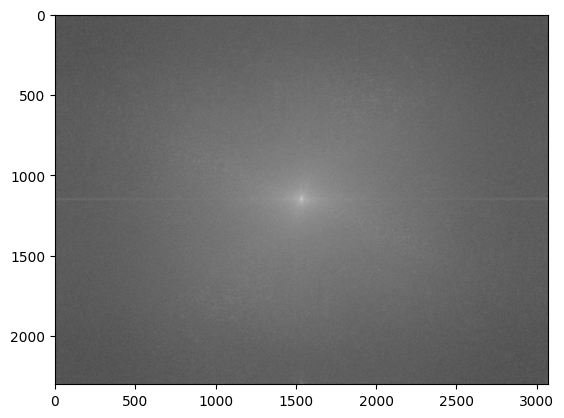

In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# img_exists = False
# path = ''

# # Enter the path of the image and check if it exists
# while not img_exists:
#     path = input("Enter the path of the image: ")
#     if (os.path.exists(path)):
#         img_exists = True
#     else:
#         print("The image \"\033[1m"
#               + str(path)
#               + "\033[0m\" has not been found.")

path = "./dataset/cover.jpg"
# Load the image in grayscale mode
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Compute the two-dimensional FFT.
f = np.fft.fft2(img)
# Swap half-spaces for all axes
fshift = np.fft.fftshift(f)
# Calculate the logarithm
magnitude_spectrum = 20*np.log(np.abs(fshift))

# Display the result with matplotlib
plt.imshow(magnitude_spectrum, cmap='gray')
plt.show()